In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa
import fnmatch 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, ConfusionMatrixDisplay

In [7]:
music_df = pd.read_csv('C:/Users/Mary/Desktop/Диплом/MER_audio_taffc_dataset/panda_dataset_taffc_metadata.csv')

In [9]:
music_df.head()

,Song,Artist,Title,Quadrant,PQuad,MoodsTotal,Moods,MoodsFoundStr,MoodsStr,MoodsStrSplit,Genres,GenresStr,Sample,SampleURL
0,MT0000004637,Charlie Poole,Bulldog Down in Sunny Tennessee,Q3,0.666667,3,3,circular; greasy; messy,Circular; Greasy; Messy,Circular; Greasy; Messy,2,Country; International,1,http://rovimusic.rovicorp.com/playback.mp3?c=l...
1,MT0000011357,Dismember,Reborn in Blasphemy,Q2,0.666667,3,3,jittery; negative; nervous,Negative; Nervous/Jittery,Negative; Nervous; Jittery,3,Electronic; International; Pop/Rock,1,http://rovimusic.rovicorp.com/playback.mp3?c=0...
2,MT0000011975,Curse of the Golden Vampire,Ultrasonic Meltdown,Q2,0.666667,6,5,fierce; harsh; hostile; menacing; outrageous,Fierce; Harsh; Hostile; Menacing; Outrageous; ...,Fierce; Harsh; Hostile; Menacing; Outrageous; ...,1,Electronic,1,http://rovimusic.rovicorp.com/playback.mp3?c=_...
3,MT0000040632,Gipsy Kings,Flamencos en el Aire,Q1,0.750000,4,3,fiery; sexy; spicy,Cathartic; Fiery; Sexy; Spicy,Cathartic; Fiery; Sexy; Spicy,2,International; Jazz,1,http://rovimusic.rovicorp.com/playback.mp3?c=G...
4,MT0000044741,Little Walter,Last Night,Q3,0.750000,4,4,greasy; gritty; gutsy; lazy,Greasy; Gritty; Gutsy; Lazy,Greasy; Gritty; Gutsy; Lazy,1,Blues,1,http://rovimusic.rovicorp.com/playback.mp3?c=k...


In [94]:
music_df['Artist'] = music_df['Artist'].isna().fillna('no_name')

# Извлечение хромограммы и составление датасета

In [35]:
# Папка с аудиофайлами
folder_path = 'C:/Users/Mary/Desktop/Диплом/all_music/'
files = fnmatch.filter(os.listdir(folder_path), '*.mp3')

# Список для хранения хромаграмм
chroma_list = []
file_names = []

for file in files:
    # Загружаем аудиофайл
    audio_path = os.path.join(folder_path, file)
    y, sr = librosa.load(audio_path, sr=None, res_type='kaiser_fast')
    
    # Вычисляем хромаграмму CQT с широкой шкалой частот (охватывает около 60 нот)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=60, n_chroma=60)
    
    # Сохраняем средние значения хромаграммы по времени
    chroma_list.append(chroma.mean(axis=1))
    file_names.append(file)

# Конвертация результатов в массив numpy
chroma_array = np.array(chroma_list)

# Вывод информации о полученных данных
print(f'Обработано {len(chroma_list)} файлов.')
print(f'Форма массива хромаграмм: {chroma_array.shape}')

Обработано 900 файлов.
Форма массива хромаграмм: (900, 60)


In [37]:
chroma_df = pd.DataFrame(chroma_list)

In [39]:
chroma_df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.443772,0.323246,0.273419,0.265752,0.279812,0.307410,0.343295,0.381698,0.404105,0.539922,...,0.421216,0.341251,0.295385,0.290910,0.248288,0.263075,0.273234,0.258989,0.300271,0.415222
1,0.533384,0.551730,0.486165,0.418510,0.421176,0.409938,0.397159,0.399229,0.386361,0.376404,...,0.387055,0.405054,0.393433,0.411496,0.413557,0.450908,0.445248,0.442369,0.451103,0.466110
2,0.370861,0.397420,0.526688,0.763953,0.719482,0.561702,0.424701,0.370711,0.414319,0.466448,...,0.411753,0.415309,0.353964,0.319828,0.327530,0.313331,0.297589,0.313480,0.339963,0.299659
3,0.175796,0.178800,0.199381,0.257791,0.432433,0.538870,0.387899,0.216214,0.171414,0.162288,...,0.343376,0.421373,0.454371,0.432721,0.456311,0.486496,0.377427,0.250039,0.205623,0.181390
4,0.377437,0.388933,0.373309,0.384422,0.387285,0.347906,0.295515,0.254130,0.288449,0.452692,...,0.231400,0.261255,0.306224,0.348963,0.391604,0.376148,0.348385,0.331108,0.353600,0.358920


In [41]:
combined_df = pd.concat([chroma_df, pd.Series(file_names, name='Song')], axis=1)

In [43]:
combined_df['Song'] = combined_df['Song'].str[:12]

In [45]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Song
0,0.443772,0.323246,0.273419,0.265752,0.279812,0.307410,0.343295,0.381698,0.404105,0.539922,...,0.341251,0.295385,0.290910,0.248288,0.263075,0.273234,0.258989,0.300271,0.415222,MT0000004637
1,0.533384,0.551730,0.486165,0.418510,0.421176,0.409938,0.397159,0.399229,0.386361,0.376404,...,0.405054,0.393433,0.411496,0.413557,0.450908,0.445248,0.442369,0.451103,0.466110,MT0000011357
2,0.370861,0.397420,0.526688,0.763953,0.719482,0.561702,0.424701,0.370711,0.414319,0.466448,...,0.415309,0.353964,0.319828,0.327530,0.313331,0.297589,0.313480,0.339963,0.299659,MT0000011975
3,0.175796,0.178800,0.199381,0.257791,0.432433,0.538870,0.387899,0.216214,0.171414,0.162288,...,0.421373,0.454371,0.432721,0.456311,0.486496,0.377427,0.250039,0.205623,0.181390,MT0000040632
4,0.377437,0.388933,0.373309,0.384422,0.387285,0.347906,0.295515,0.254130,0.288449,0.452692,...,0.261255,0.306224,0.348963,0.391604,0.376148,0.348385,0.331108,0.353600,0.358920,MT0000044741


In [47]:
merged_df = pd.merge(music_df, combined_df, on='Song', how='left')

In [49]:
merged_df.head(5)

,Song,Artist,Title,Quadrant,PQuad,MoodsTotal,Moods,MoodsFoundStr,MoodsStr,MoodsStrSplit,...,50,51,52,53,54,55,56,57,58,59
0,MT0000004637,Charlie Poole,Bulldog Down in Sunny Tennessee,Q3,0.666667,3,3,circular; greasy; messy,Circular; Greasy; Messy,Circular; Greasy; Messy,...,0.421216,0.341251,0.295385,0.290910,0.248288,0.263075,0.273234,0.258989,0.300271,0.415222
1,MT0000011357,Dismember,Reborn in Blasphemy,Q2,0.666667,3,3,jittery; negative; nervous,Negative; Nervous/Jittery,Negative; Nervous; Jittery,...,0.387055,0.405054,0.393433,0.411496,0.413557,0.450908,0.445248,0.442369,0.451103,0.466110
2,MT0000011975,Curse of the Golden Vampire,Ultrasonic Meltdown,Q2,0.666667,6,5,fierce; harsh; hostile; menacing; outrageous,Fierce; Harsh; Hostile; Menacing; Outrageous; ...,Fierce; Harsh; Hostile; Menacing; Outrageous; ...,...,0.411753,0.415309,0.353964,0.319828,0.327530,0.313331,0.297589,0.313480,0.339963,0.299659
3,MT0000040632,Gipsy Kings,Flamencos en el Aire,Q1,0.750000,4,3,fiery; sexy; spicy,Cathartic; Fiery; Sexy; Spicy,Cathartic; Fiery; Sexy; Spicy,...,0.343376,0.421373,0.454371,0.432721,0.456311,0.486496,0.377427,0.250039,0.205623,0.181390
4,MT0000044741,Little Walter,Last Night,Q3,0.750000,4,4,greasy; gritty; gutsy; lazy,Greasy; Gritty; Gutsy; Lazy,Greasy; Gritty; Gutsy; Lazy,...,0.231400,0.261255,0.306224,0.348963,0.391604,0.376148,0.348385,0.331108,0.353600,0.358920


In [55]:
final_df = merged_df[['Quadrant'] + list(merged_df.columns[-60:])]
#merged_df = pd.concat(merged_df['Quadrant'], combined_df)
final_df.head()

,Quadrant,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,Q3,0.443772,0.323246,0.273419,0.265752,0.279812,0.307410,0.343295,0.381698,0.404105,...,0.421216,0.341251,0.295385,0.290910,0.248288,0.263075,0.273234,0.258989,0.300271,0.415222
1,Q2,0.533384,0.551730,0.486165,0.418510,0.421176,0.409938,0.397159,0.399229,0.386361,...,0.387055,0.405054,0.393433,0.411496,0.413557,0.450908,0.445248,0.442369,0.451103,0.466110
2,Q2,0.370861,0.397420,0.526688,0.763953,0.719482,0.561702,0.424701,0.370711,0.414319,...,0.411753,0.415309,0.353964,0.319828,0.327530,0.313331,0.297589,0.313480,0.339963,0.299659
3,Q1,0.175796,0.178800,0.199381,0.257791,0.432433,0.538870,0.387899,0.216214,0.171414,...,0.343376,0.421373,0.454371,0.432721,0.456311,0.486496,0.377427,0.250039,0.205623,0.181390
4,Q3,0.377437,0.388933,0.373309,0.384422,0.387285,0.347906,0.295515,0.254130,0.288449,...,0.231400,0.261255,0.306224,0.348963,0.391604,0.376148,0.348385,0.331108,0.353600,0.358920


# Разделене выборки на обучающую и тестовую

In [57]:
X = final_df.drop('Quadrant',axis=1)
y = final_df['Quadrant']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

In [59]:
scaler = StandardScaler()
scal_X_train = scaler.fit_transform(X_train)
scal_X_test = scaler.transform(X_test)

# Случайный лес

In [61]:
n_estimators=[128, 140, 150, 200]
max_features= [3,4,5]
bootstrap = [True]
oob_score = [True]
criterion =['gini', 'entropy']

In [63]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score,
             'criterion': criterion,
             }

In [65]:
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc,param_grid)

In [67]:
rfc_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_features': [3, 4, 5],
                         'n_estimators': [128, 140, 150, 200],
                         'oob_score': [True]})

In [69]:
rfc_grid.best_params_ 

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 4,
 'n_estimators': 150,
 'oob_score': True}

In [71]:
rfc_pred = rfc_grid.predict(X_test)

In [73]:
print(classification_report(rfc_pred, y_test))

              precision    recall  f1-score   support

          Q1       0.54      0.45      0.49        42
          Q2       0.61      0.62      0.62        32
          Q3       0.70      0.52      0.60        44
          Q4       0.35      0.71      0.47        17

    accuracy                           0.55       135
   macro avg       0.55      0.58      0.54       135
weighted avg       0.58      0.55      0.55       135



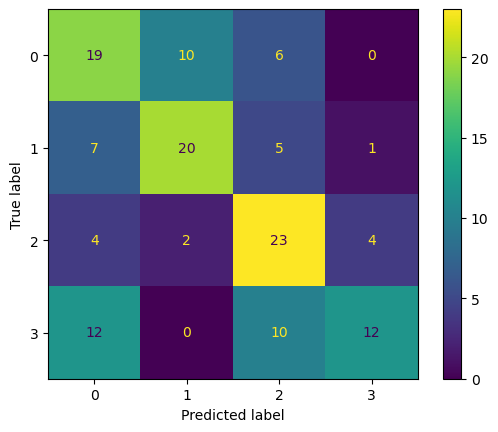

In [75]:
ConfusionMatrixDisplay(confusion_matrix(y_test,rfc_pred)).plot()

# RandomForestClassifier подбор параметров halving

In [77]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Определяем пространство гиперпараметров
param_dist = {
    'n_estimators': np.linspace(10, 200, 10, dtype=int),
    'max_features': np.linspace(1, X_train.shape[1], 5, dtype=int),
    'max_depth': [None] + list(np.linspace(5, 50, 10, dtype=int)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаём классификатор
clf = RandomForestClassifier()

# Запускаем HalvingRandomSearchCV
halving_rs = HalvingRandomSearchCV(
    clf, param_dist, factor=3,  # Оставляем треть лучших на каждой итерации
    resource='n_samples', min_resources=30,
    cv=3, random_state=42
)
halving_rs.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", halving_rs.best_params_)

Лучшие параметры: {'n_estimators': 136, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 60, 'max_depth': 45}


In [83]:
clf = RandomForestClassifier(n_estimators=136, min_samples_split=5, min_samples_leaf=1, max_features=60, max_depth=45)

In [85]:
clf_pred = halving_rs.predict(X_test)

In [87]:
print(classification_report(clf_pred, y_test))

              precision    recall  f1-score   support

          Q1       0.46      0.44      0.45        36
          Q2       0.55      0.51      0.53        35
          Q3       0.64      0.46      0.53        46
          Q4       0.32      0.61      0.42        18

    accuracy                           0.49       135
   macro avg       0.49      0.51      0.48       135
weighted avg       0.52      0.49      0.50       135



In [1]:
#help(clf)

# CatBoostClassifier halving

In [95]:
#pip install catboost

In [141]:
from catboost import CatBoostClassifier

# Создаём модель CatBoost (без предобучения)
clf = CatBoostClassifier(
    verbose=0,  # Отключаем вывод во время обучения
    random_state=42
)

# Определяем пространство гиперпараметров
param_dist = {
    'iterations': np.linspace(100, 1000, 5, dtype=int),
    'learning_rate': np.logspace(-3, 0, 5),
    'depth': np.arange(4, 11),
    'l2_leaf_reg': np.logspace(-2, 2, 5),
    'border_count': np.linspace(32, 255, 5, dtype=int)
}

# Запускаем HalvingRandomSearchCV
halving_rs = HalvingRandomSearchCV(
    clf, param_dist, factor=3,  
    resource='n_samples', min_resources=30,
    cv=3, random_state=42
)

# Обучаем модель
halving_rs.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", halving_rs.best_params_)

# Оцениваем модель
best_model = halving_rs.best_estimator_
print("Accuracy:", best_model.score(X_test, y_test))


Лучшие параметры: {'learning_rate': 0.005623413251903491, 'l2_leaf_reg': 0.1, 'iterations': 550, 'depth': 4, 'border_count': 143}
Accuracy: 0.5925925925925926


In [97]:
cbc_halving = CatBoostClassifier(learning_rate=0.005623413251903491, l2_leaf_reg=0.1, iterations=550, depth=4, border_count=143)

In [99]:
cbc_halving_pred = halving_rs.predict(X_test)

In [101]:
print(classification_report(cbc_halving_pred, y_test))

              precision    recall  f1-score   support

          Q1       0.46      0.44      0.45        36
          Q2       0.55      0.51      0.53        35
          Q3       0.64      0.46      0.53        46
          Q4       0.32      0.61      0.42        18

    accuracy                           0.49       135
   macro avg       0.49      0.51      0.48       135
weighted avg       0.52      0.49      0.50       135



# ПРОБУЮ ДРУГОЙ ПОДХОД

# Только хромограмма 3-х видов

In [3]:
import os
import fnmatch
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler

# Папка с аудиофайлами
folder_path = 'C:/Users/Mary/Desktop/Диплом/all_music/'
files = fnmatch.filter(os.listdir(folder_path), '*.mp3')

# Списки для хранения признаков и имен файлов
chroma_features_list = []
file_names = []

for file in files:
    # Загружаем аудиофайл
    audio_path = os.path.join(folder_path, file)
    y, sr = librosa.load(audio_path, sr=None, res_type='kaiser_fast')

    # 🔹 1. Хромаграмма CQT (широкий частотный диапазон)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=60, n_chroma=60)
    
    # 🔹 2. Хромаграмма STFT (учитывает динамику атаки)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

    # 🔹 3. Хромаграмма CENS (устойчива к шуму)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

    # 🔹 4. Логарифмирование хромаграмм (чтобы выделить слабые ноты)
    chroma_cqt = np.log1p(chroma_cqt)
    chroma_stft = np.log1p(chroma_stft)
    chroma_cens = np.log1p(chroma_cens)

    # 🔹 5. Вычисляем статистики по каждой хромаграмме
    def extract_statistics(feature):
        return np.hstack([
            np.mean(feature, axis=1),    # Среднее
            np.std(feature, axis=1),     # Стандартное отклонение
            np.median(feature, axis=1),  # Медиана
            np.max(feature, axis=1) - np.min(feature, axis=1)  # Размах
        ])

    chroma_cqt_stats = extract_statistics(chroma_cqt)
    chroma_stft_stats = extract_statistics(chroma_stft)
    chroma_cens_stats = extract_statistics(chroma_cens)

    # 🔹 6. Объединяем все статистики в единый вектор
    chroma_features = np.hstack([chroma_cqt_stats, chroma_stft_stats, chroma_cens_stats])

    # Добавляем в список
    chroma_features_list.append(chroma_features)
    file_names.append(file)

# Преобразуем в numpy массив
chroma_array = np.array(chroma_features_list)

# 🔹 7. Нормализация признаков (ускоряет обучение моделей)
scaler = StandardScaler()
chroma_array_scaled = scaler.fit_transform(chroma_array)

# Вывод информации о данных
print(f'Обработано {len(chroma_features_list)} файлов.')
print(f'Форма массива хромаграмм: {chroma_array_scaled.shape}')


Обработано 900 файлов.
Форма массива хромаграмм: (900, 336)


In [12]:
chroma_df = pd.DataFrame(chroma_features_list)

In [10]:
chroma_df.to_csv(r'C:\Users\Mary\Desktop\Диплом\cqt_stft_cens_chromas_df.csv')

# Только mfcc и mel

In [14]:
mel_list = []
mfcc_list = []
file_names = []

folder_path = 'C:/Users/Mary/Desktop/Диплом/all_music/'
files = fnmatch.filter(os.listdir(folder_path), '*.mp3')   

for file in files:
    audio_path = os.path.join(folder_path, file)
    y, sr = librosa.load(audio_path, sr=None, res_type='kaiser_fast')

    # Вычисляем Mel-спектрограмму
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_list.append(mel.mean(axis=1))

    # Вычисляем MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_list.append(mfcc.mean(axis=1))

    file_names.append(file)


In [16]:
mfcc_df = pd.DataFrame(mfcc_list)
mel_df = pd.DataFrame(mel_list)

In [18]:
mfcc_df.to_csv(r'C:\Users\Mary\Desktop\Диплом\mfcc_df.csv')
mel_df.to_csv(r'C:\Users\Mary\Desktop\Диплом\mel_df.csv')

# Темп 

In [20]:
tempo_list = []
file_names = []

folder_path = 'C:/Users/Mary/Desktop/Диплом/all_music/'
files = fnmatch.filter(os.listdir(folder_path), '*.mp3')

for file in files:
    audio_path = os.path.join(folder_path, file)
    y, sr = librosa.load(audio_path, sr=None, res_type='kaiser_fast')

    # Вычисляем темп (BPM)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    tempo_list.append(tempo)  # Добавляем темп в список

    file_names.append(file)
    
tempo_df = pd.DataFrame(tempo_list)

# Выводим информацию
print(f'Обработано {len(file_names)} файлов.')
print(f'Форма Tempo: {tempo_df.shape}')


Обработано 900 файлов.
Форма Tempo: (900, 1)


# Итоговый датасет

In [103]:
cqt_stft_cens_chromas_df = pd.read_csv('C:/Users/Mary/Desktop/Диплом/cqt_stft_cens_chromas_df.csv')

In [105]:
mel_df = pd.read_csv('C:/Users/Mary/Desktop/Диплом/mel_df.csv')

In [107]:
mfcc_df = pd.read_csv('C:/Users/Mary/Desktop/Диплом/mfcc_df.csv')

In [109]:
df_combined = pd.concat([cqt_stft_cens_chromas_df, mel_df, mfcc_df, tempo_df], axis=1)

In [111]:
df_combined = df_combined.iloc[:, 1:]

In [113]:
df_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,0
0,0.344369,0.267671,0.231999,0.226553,0.236617,0.256444,0.282879,0.309561,0.325702,0.414427,...,-0.020307,2.324166,3.567792,3.883560,-1.823020,-2.058319,-5.530811,-2.079775,-2.063657,163.043478
1,0.413149,0.422476,0.382707,0.338075,0.339839,0.332445,0.323744,0.324923,0.316282,0.309919,...,-1.688632,-3.825361,-0.613288,-3.535904,-4.854705,-1.428813,-8.155371,0.105861,-4.854570,135.999178
2,0.310428,0.328462,0.413456,0.555491,0.530212,0.436717,0.347030,0.308844,0.339200,0.370777,...,-2.085293,-2.503842,-4.341682,-2.598336,-3.895138,-0.943562,-4.858965,0.452470,-4.311635,101.351351
3,0.159420,0.161369,0.177484,0.220572,0.341637,0.407468,0.316527,0.190813,0.155512,0.147535,...,1.663398,-3.054370,-3.469282,0.551196,-2.130995,1.955830,-1.407931,4.732381,-2.828623,98.684211
4,0.311646,0.319286,0.308918,0.314276,0.316000,0.288682,0.250883,0.219238,0.244121,0.351694,...,-2.719656,-4.388300,0.210486,0.959180,-0.584419,3.384225,-4.916590,1.795105,-4.837695,66.964286


In [115]:
df_combined.columns = range(df_combined.shape[1])

In [117]:
df_combined[0]

0      0.344369
1      0.413149
2      0.310428
3      0.159420
4      0.311646
         ...   
895    0.447475
896    0.401390
897    0.361099
898    0.225305
899    0.499234
Name: 0, Length: 900, dtype: float64

In [119]:
chroma_df = df_combined

In [121]:
music_df = pd.read_csv('C:/Users/Mary/Desktop/Диплом/MER_audio_taffc_dataset/panda_dataset_taffc_metadata.csv')

In [123]:
music_df['Artist'] = music_df['Artist'].isna().fillna('no_name')

In [125]:
chroma_df.head()

,0,1,2,3,4,5,6,7,8,9,...,497,498,499,500,501,502,503,504,505,506
0,0.344369,0.267671,0.231999,0.226553,0.236617,0.256444,0.282879,0.309561,0.325702,0.414427,...,-0.020307,2.324166,3.567792,3.883560,-1.823020,-2.058319,-5.530811,-2.079775,-2.063657,163.043478
1,0.413149,0.422476,0.382707,0.338075,0.339839,0.332445,0.323744,0.324923,0.316282,0.309919,...,-1.688632,-3.825361,-0.613288,-3.535904,-4.854705,-1.428813,-8.155371,0.105861,-4.854570,135.999178
2,0.310428,0.328462,0.413456,0.555491,0.530212,0.436717,0.347030,0.308844,0.339200,0.370777,...,-2.085293,-2.503842,-4.341682,-2.598336,-3.895138,-0.943562,-4.858965,0.452470,-4.311635,101.351351
3,0.159420,0.161369,0.177484,0.220572,0.341637,0.407468,0.316527,0.190813,0.155512,0.147535,...,1.663398,-3.054370,-3.469282,0.551196,-2.130995,1.955830,-1.407931,4.732381,-2.828623,98.684211
4,0.311646,0.319286,0.308918,0.314276,0.316000,0.288682,0.250883,0.219238,0.244121,0.351694,...,-2.719656,-4.388300,0.210486,0.959180,-0.584419,3.384225,-4.916590,1.795105,-4.837695,66.964286


In [127]:
combined_df = pd.concat([chroma_df, pd.Series(file_names, name='Song')], axis=1)

In [129]:
combined_df['Song'] = combined_df['Song'].str[:12]

In [131]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,498,499,500,501,502,503,504,505,506,Song
0,0.344369,0.267671,0.231999,0.226553,0.236617,0.256444,0.282879,0.309561,0.325702,0.414427,...,2.324166,3.567792,3.883560,-1.823020,-2.058319,-5.530811,-2.079775,-2.063657,163.043478,MT0000004637
1,0.413149,0.422476,0.382707,0.338075,0.339839,0.332445,0.323744,0.324923,0.316282,0.309919,...,-3.825361,-0.613288,-3.535904,-4.854705,-1.428813,-8.155371,0.105861,-4.854570,135.999178,MT0000011357
2,0.310428,0.328462,0.413456,0.555491,0.530212,0.436717,0.347030,0.308844,0.339200,0.370777,...,-2.503842,-4.341682,-2.598336,-3.895138,-0.943562,-4.858965,0.452470,-4.311635,101.351351,MT0000011975
3,0.159420,0.161369,0.177484,0.220572,0.341637,0.407468,0.316527,0.190813,0.155512,0.147535,...,-3.054370,-3.469282,0.551196,-2.130995,1.955830,-1.407931,4.732381,-2.828623,98.684211,MT0000040632
4,0.311646,0.319286,0.308918,0.314276,0.316000,0.288682,0.250883,0.219238,0.244121,0.351694,...,-4.388300,0.210486,0.959180,-0.584419,3.384225,-4.916590,1.795105,-4.837695,66.964286,MT0000044741


In [133]:
merged_df = pd.merge(music_df, combined_df, on='Song', how='left')

In [135]:
merged_df.head(5)

,Song,Artist,Title,Quadrant,PQuad,MoodsTotal,Moods,MoodsFoundStr,MoodsStr,MoodsStrSplit,...,497,498,499,500,501,502,503,504,505,506
0,MT0000004637,False,Bulldog Down in Sunny Tennessee,Q3,0.666667,3,3,circular; greasy; messy,Circular; Greasy; Messy,Circular; Greasy; Messy,...,-0.020307,2.324166,3.567792,3.883560,-1.823020,-2.058319,-5.530811,-2.079775,-2.063657,163.043478
1,MT0000011357,False,Reborn in Blasphemy,Q2,0.666667,3,3,jittery; negative; nervous,Negative; Nervous/Jittery,Negative; Nervous; Jittery,...,-1.688632,-3.825361,-0.613288,-3.535904,-4.854705,-1.428813,-8.155371,0.105861,-4.854570,135.999178
2,MT0000011975,False,Ultrasonic Meltdown,Q2,0.666667,6,5,fierce; harsh; hostile; menacing; outrageous,Fierce; Harsh; Hostile; Menacing; Outrageous; ...,Fierce; Harsh; Hostile; Menacing; Outrageous; ...,...,-2.085293,-2.503842,-4.341682,-2.598336,-3.895138,-0.943562,-4.858965,0.452470,-4.311635,101.351351
3,MT0000040632,False,Flamencos en el Aire,Q1,0.750000,4,3,fiery; sexy; spicy,Cathartic; Fiery; Sexy; Spicy,Cathartic; Fiery; Sexy; Spicy,...,1.663398,-3.054370,-3.469282,0.551196,-2.130995,1.955830,-1.407931,4.732381,-2.828623,98.684211
4,MT0000044741,False,Last Night,Q3,0.750000,4,4,greasy; gritty; gutsy; lazy,Greasy; Gritty; Gutsy; Lazy,Greasy; Gritty; Gutsy; Lazy,...,-2.719656,-4.388300,0.210486,0.959180,-0.584419,3.384225,-4.916590,1.795105,-4.837695,66.964286


In [137]:
final_df = merged_df[['Quadrant'] + list(merged_df.columns[-507:])]
#merged_df = pd.concat(merged_df['Quadrant'], combined_df)
final_df.head()

,Quadrant,0,1,2,3,4,5,6,7,8,...,497,498,499,500,501,502,503,504,505,506
0,Q3,0.344369,0.267671,0.231999,0.226553,0.236617,0.256444,0.282879,0.309561,0.325702,...,-0.020307,2.324166,3.567792,3.883560,-1.823020,-2.058319,-5.530811,-2.079775,-2.063657,163.043478
1,Q2,0.413149,0.422476,0.382707,0.338075,0.339839,0.332445,0.323744,0.324923,0.316282,...,-1.688632,-3.825361,-0.613288,-3.535904,-4.854705,-1.428813,-8.155371,0.105861,-4.854570,135.999178
2,Q2,0.310428,0.328462,0.413456,0.555491,0.530212,0.436717,0.347030,0.308844,0.339200,...,-2.085293,-2.503842,-4.341682,-2.598336,-3.895138,-0.943562,-4.858965,0.452470,-4.311635,101.351351
3,Q1,0.159420,0.161369,0.177484,0.220572,0.341637,0.407468,0.316527,0.190813,0.155512,...,1.663398,-3.054370,-3.469282,0.551196,-2.130995,1.955830,-1.407931,4.732381,-2.828623,98.684211
4,Q3,0.311646,0.319286,0.308918,0.314276,0.316000,0.288682,0.250883,0.219238,0.244121,...,-2.719656,-4.388300,0.210486,0.959180,-0.584419,3.384225,-4.916590,1.795105,-4.837695,66.964286


In [ ]:
final_df.to_csv(r'C:\Users\Mary\Desktop\Диплом\final_df.csv')

# Разделение датасета

In [15]:
final_df = pd.read_csv('C:/Users/Mary/Desktop/Диплом/final_df.csv')

In [9]:
c = pd.read_csv('C:/Users/Mary/Desktop/Диплом/cqt_stft_cens_chromas_df.csv')

In [17]:
final_df.shape

(900, 509)

In [5]:
X = final_df.drop('Quadrant',axis=1)
y = final_df['Quadrant']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [7]:
scaler = StandardScaler()
scal_X_train = scaler.fit_transform(X_train)
scal_X_test = scaler.transform(X_test)

# Optuna в rfc

In [153]:
#pip install optuna

In [185]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Оптимизируем гиперпараметры
def objective(trial):
    # Подбираемые параметры
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # Количество деревьев
    max_depth = trial.suggest_int("max_depth", 2, 50)  # Глубина деревьев
    min_samples_split = trial.suggest_float("min_samples_split", 0.01, 0.5)  # Мин. число объектов для разбиения
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)  # Мин. число объектов в листе
    max_features = trial.suggest_float("max_features", 0.1, 1.0)  # Доля признаков для построения каждого дерева
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])  # Использовать бутстрап?

    # Определяем модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1  # Параллельный запуск
    )

    # Кросс-валидация (StratifiedKFold для лучшего баланса классов)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy", n_jobs=-1).mean()
    
    return score  # Оптимизируем точность

# Запускаем Optuna с Pruner (отбрасывание слабых комбинаций)
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, n_jobs=-1)  # Больше итераций

# Вывод лучших параметров
print("Лучшие параметры:", study.best_params)
print("Лучший результат:", study.best_value)


[I 2025-03-08 22:05:57,639] A new study created in memory with name: no-name-f02f6f26-eb3a-49f1-a99e-5ec3e4c596c7
[I 2025-03-08 22:06:52,353] Trial 3 finished with value: 0.5738562091503268 and parameters: {'n_estimators': 173, 'max_depth': 47, 'min_samples_split': 0.3082299057445912, 'min_samples_leaf': 3, 'max_features': 0.22067866430454208, 'bootstrap': False}. Best is trial 3 with value: 0.5738562091503268.
[I 2025-03-08 22:07:04,510] Trial 7 finished with value: 0.584313725490196 and parameters: {'n_estimators': 290, 'max_depth': 47, 'min_samples_split': 0.04271740354422055, 'min_samples_leaf': 6, 'max_features': 0.39863261940329353, 'bootstrap': False}. Best is trial 7 with value: 0.584313725490196.
[I 2025-03-08 22:07:10,447] Trial 5 finished with value: 0.5699346405228758 and parameters: {'n_estimators': 177, 'max_depth': 48, 'min_samples_split': 0.38064194185007943, 'min_samples_leaf': 12, 'max_features': 0.2367829658633477, 'bootstrap': False}. Best is trial 7 with value: 0.5

Лучшие параметры: {'n_estimators': 387, 'max_depth': 10, 'min_samples_split': 0.010245918919697478, 'min_samples_leaf': 13, 'max_features': 0.20246386097397454, 'bootstrap': False}
Лучший результат: 0.6169934640522876


In [193]:
optuna_rfc = RandomForestClassifier(n_estimators=387, max_depth=10, min_samples_split=0.010245918919697478, min_samples_leaf=13, max_features=0.20246386097397454, bootstrap=False)
optuna_rfc.fit(X_train,y_train)
optuna_rfc_preds = optuna_rfc.predict(X_test)

In [195]:
print(classification_report(y_test,optuna_rfc_preds))

              precision    recall  f1-score   support

          Q1       0.66      0.61      0.63        41
          Q2       0.71      0.80      0.75        40
          Q3       0.69      0.64      0.67        28
          Q4       0.65      0.65      0.65        26

    accuracy                           0.68       135
   macro avg       0.68      0.68      0.68       135
weighted avg       0.68      0.68      0.68       135



# Optuna в CatBoost

In [9]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier

# Функция для оптимизации
def objective(trial):
 
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 6, 10),  
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1), 
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 5.0),  
        "border_count": trial.suggest_int("border_count", 50, 100),  
        "loss_function": "MultiClass", 
        "eval_metric": "Accuracy",
        "verbose": 0,
        "random_state": 42,
        "task_type": "GPU" if CatBoostClassifier().get_param("task_type") == "GPU" else "CPU",  
        "early_stopping_rounds": 50  
    }

    # Создаём модель
    model = CatBoostClassifier(**params)

    # Кросс-валидация
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy", n_jobs=-1).mean()
    
    return score  

# Оптимизация
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=30, n_jobs=-1)

# Лучшие параметры
print("Лучшие параметры:", study.best_params)
print("Лучший результат:", study.best_value)


[I 2025-03-12 20:32:48,171] A new study created in memory with name: no-name-844d38db-dff6-4a59-8146-9b52e4f2c66f
C:\Users\Mary\AppData\Local\Temp\ipykernel_8508\1127732574.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
C:\Users\Mary\AppData\Local\Temp\ipykernel_8508\1127732574.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 5.0),
C:\Users\Mary\AppData\Local\Temp\ipykernel_8508\1127732574.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

Лучшие параметры: {'iterations': 376, 'depth': 7, 'learning_rate': 0.03591338854313402, 'l2_leaf_reg': 4.806012493315716, 'border_count': 79}
Лучший результат: 0.6039215686274509


In [11]:
optuna_cbc = CatBoostClassifier(iterations=376, depth=7, learning_rate=0.03591338854313402, l2_leaf_reg=4.806012493315716, border_count=79)
optuna_cbc.fit(X_train,y_train)
optuna_cbc_preds = optuna_cbc.predict(X_test)

0:	learn: 1.3696488	total: 321ms	remaining: 2m
1:	learn: 1.3538293	total: 493ms	remaining: 1m 32s
2:	learn: 1.3391763	total: 681ms	remaining: 1m 24s
3:	learn: 1.3255955	total: 847ms	remaining: 1m 18s
4:	learn: 1.3135272	total: 1.02s	remaining: 1m 15s
5:	learn: 1.3004374	total: 1.21s	remaining: 1m 14s
6:	learn: 1.2885012	total: 1.42s	remaining: 1m 15s
7:	learn: 1.2751855	total: 1.59s	remaining: 1m 13s
8:	learn: 1.2633083	total: 1.81s	remaining: 1m 14s
9:	learn: 1.2531274	total: 1.99s	remaining: 1m 12s
10:	learn: 1.2435266	total: 2.2s	remaining: 1m 13s
11:	learn: 1.2316884	total: 2.38s	remaining: 1m 12s
12:	learn: 1.2200039	total: 2.57s	remaining: 1m 11s
13:	learn: 1.2101535	total: 2.76s	remaining: 1m 11s
14:	learn: 1.1974524	total: 2.95s	remaining: 1m 11s
15:	learn: 1.1870188	total: 3.15s	remaining: 1m 10s
16:	learn: 1.1770081	total: 3.35s	remaining: 1m 10s
17:	learn: 1.1683630	total: 3.52s	remaining: 1m 9s
18:	learn: 1.1592604	total: 3.72s	remaining: 1m 9s
19:	learn: 1.1507031	total: 3

In [13]:
print(classification_report(y_test,optuna_cbc_preds))

              precision    recall  f1-score   support

          Q1       0.65      0.63      0.64        41
          Q2       0.71      0.75      0.73        40
          Q3       0.65      0.61      0.63        28
          Q4       0.59      0.62      0.60        26

    accuracy                           0.66       135
   macro avg       0.65      0.65      0.65       135
weighted avg       0.66      0.66      0.66       135

